this notebook best viewed here: http://nbviewer.jupyter.org

#### Purpose

We ran the same population as individuals (indSeq) and as a pool (poolSeq).

Here I read in the data, filter for the intersection of common loci, and then explore the data a bit.

I had coded the pipeline to also capture loci that are biallelic (two alleles) but neither of these alleles were the reference (since we're using a reference from a different species). Normally, pipelines will only keep biallelic SNPs where one of the alleles is the reference allele. In any case, I discard them here because there aren't very many of them.

#### Conclusions

It's probably OK to leave in the noREF SNPs, the frequency is estimated (more or less) pretty similarly between GATK and VarScan (even if the alleles are not the same), but since there aren't very many I decided to discard them from further analyses.

In [1]:
from pythonimports import *
methodsdir = makedir('/data/home/lindb/methods_paper_analysis')
firstdir = makedir(op.join(methodsdir, '001_testdata_explore'))

# get the snptables, do some minor filtering
- read in data
- filter for intersecting loci
- save to .pkl

In [2]:
# get the file names
sppfiles = {'gatk':{'JP': '/data/projects/pool_seq/non-pangenome/gatk_diploid_testdata/JP_i101-gatk/filtered_snps/JP_i101_filtered_concatenated_snps_max-missing_table_biallelic-only_translated.txt',
                   'DF': '/data/projects/pool_seq/non-pangenome/gatk_diploid_testdata/DF_i52-gatk/filtered_snps/DF_i52_filtered_concatenated_snps_max-missing_table_biallelic-only_p000_translated.txt'},
           'varscan':{'JP': '/data/projects/pool_seq/non-pangenome/varscan_pooled/JP_pooled/snpsANDindels/JP_pooled-varscan_all_bedfiles_SNP_translated.txt',
                      'DF': '/data/projects/pool_seq/non-pangenome/varscan_pooled/DF_p52/snpsANDindels/DF_p52-varscan_all_bedfiles_SNP.txt'}}

In [3]:
# make sure I copied them correctly
for method,spp in sppfiles.items():
    for sp,f in spp.items():
        assert op.exists(f)

In [26]:
# read in the tables
tablecols = ['CHROM','POS','REF','ALT','AF','QUAL','TYPE','FILTER','ADP','WT','HET','HOM','NC']
snps = {}
for method in sppfiles:
    print(method)
    snps[method] = {}
    for spp in sppfiles[method]:
        print('\t',spp)
        snps[method][spp] = pd.read_table(sppfiles[method][spp])
        if method == 'varscan' and spp == 'JP':
            # i ran all pools, isolate JP_p101 calls
            locuscols = [col for col in snps[method][spp] if 'locus' in col]
            snps[method][spp] = snps[method][spp][tablecols + ['JP_p101.GT','JP_p101.GQ','JP_p101.SDP',
                                                               'JP_p101.DP','JP_p101.FREQ','JP_p101.PVAL'] +locuscols]
            # remove AF=0 (because SNPs were called across all pools, JP_p101 can have AF=0)
            # AF=0 wouldn't be possible if calling AFs on a single pool
            snps[method][spp] = snps[method][spp][snps[method][spp]['JP_p101.FREQ'] != "0%"]
            # remove rows with no calls
            snps[method][spp] = snps[method][spp][snps[method][spp]['JP_p101.FREQ'] == snps[method][spp]['JP_p101.FREQ']]
            # fill in AF column
            snps[method][spp]['AF'] = snps[method][spp]['JP_p101.FREQ'].str.replace("%", "").astype(float)/100
        elif method =='varscan' and spp == 'DF':
            df = snps[method][spp]  # view, will changes go to snps['varscan']['DF']
            # add in a ">" so locus names match between gatk and varscan
            df['CHROM'] = [f">{chrom}" for chrom in df['CHROM'].tolist()]
            df['locus'] = [f">{locus}" for locus in df['locus'].tolist()]
# note varscan will output AF=0 (fixed for REF), I'm leaving these in so we can compare AFs of these too

gatk
	 JP
	 DF
varscan
	 JP
	 DF


In [27]:
# look at allele freqs
for method in snps:
    for spp,df in snps[method].items():
        print(spp, method, min(df['AF']), max(df['AF']))

JP gatk 0.025 1.0
DF gatk 0.025 1.0
JP varscan 0.0001 1.0
DF varscan 0.0039 1.0


In [28]:
# look at num snps and cols
for method in snps:
    for spp,df in snps[method].items():
        print(spp, method, df.shape)

JP gatk (378713, 117)
DF gatk (1527720, 117)
JP varscan (3686528, 21)
DF varscan (1601285, 21)


In [29]:
# make sure columns are there that I want
for method in snps:
    for spp,df in snps[method].items():
        cols = [col for col in df.columns if 'locus' in col]
        print(method, spp, cols)

gatk JP ['locus', 'unstitched_locus']
gatk DF ['locus', 'unstitched_locus']
varscan JP ['locus', 'unstitched_locus']
varscan DF ['locus']


#### filter for intersecting loci

In [6]:
def getlocuscol(df):
    """Determine which column contains the locus name."""
    return 'unstitched_locus' if 'unstitched_locus' in df else 'locus'

In [30]:
# get the list of loci
methodloci = {}
for method in snps:
    for spp in snps[method]:
        df = snps[method][spp]
        locuscol = getlocuscol(df)
        print(method, spp, locuscol)
        if spp not in methodloci:
            methodloci[spp] = []
        methodloci[spp].append(df[locuscol].tolist())
# for spp,lsts in methodloci.items():
#     print(spp,len(lsts), type(lsts), type(lsts[0]), type(lsts[1]))

gatk JP unstitched_locus
gatk DF unstitched_locus
varscan JP unstitched_locus
varscan DF locus


In [31]:
methodloci['DF'][0][:5]

['>jcf7190000000231-59482',
 '>jcf7190000000231-108467',
 '>jcf7190000000275-99191',
 '>jcf7190000000290-96627',
 '>jcf7190000000366-177185']

In [32]:
methodloci['DF'][1][:5]

['>jcf7190000000000-77616',
 '>jcf7190000000000-77656',
 '>jcf7190000000000-77657',
 '>jcf7190000000000-77729',
 '>jcf7190000000000-77738']

In [33]:
methodloci['JP'][0][:5]

['>super808-865131',
 '>super819-359621',
 '>super896-944540',
 '>super1256-476207',
 '>super1349-138470']

In [34]:
methodloci['JP'][1][:5]

['>super4-15421',
 '>super4-15496',
 '>super4-47156',
 '>super4-47333',
 '>super4-47395']

In [35]:
# get intersection
# indexing assumes only two methods
interloci = {}
for spp in methodloci:
    interloci[spp] = set(methodloci[spp][0]).intersection(methodloci[spp][1])
    print(spp, len(interloci[spp]))

JP 256950
DF 637410


In [95]:
# reduce to intersection
for method,spp in snps.items():
    for sp,df in spp.items():
        locuscol = getlocuscol(df)
        print(method, sp, nrow(df))
        snps[method][sp] = df[df[locuscol].isin(interloci[sp])].copy()
        print('\t', method, sp, nrow(snps[method][sp]))

gatk JP 378713
	 gatk JP 256950
gatk DF 1527720
	 gatk DF 637410
varscan JP 3686528
	 varscan JP 256950
varscan DF 1601285
	 varscan DF 637410


In [96]:
# save so I don't have to reload and refilter
pklfile = op.join(firstdir, 'snps_dict_intersecting_loci.pkl')
pkldump(snps, pklfile)

In [2]:
# load data
snps = pklload(op.join(firstdir, 'snps_dict_intersecting_loci.pkl'))

In [ ]:
# data after removing noREF snps is saved below as a pkl

# before removing noREF SNPs, compare to varscan

noREF SNPs are a biallelic SNPs that do not have the reference allele (from gatk pipeline). I'll eventually remove these, but curious what's happening at the same loci called with VarScan (that only would have called true biallelic SNPs).

- first compare to noREF snps in the gatk table (later expand to all data before filtering)
- plot relationship
- redo VariantsToTable on each bedfile-produced vcf, look at effect across all data 

Conclusion: Even if VarScan does not call a site multiallelic that was called multiallelic by gatk, the estimated AF is still similar when considering the alt. In other words, even when GATK and VarScan disagree on the specific alleles, they agree (more or less) on AF.

#### first compare to noREF snps in the gatk table (later expand to all data before filtering)

In [4]:
# make sure only gatk has noREF snps
for method,spp in snps.items():
    for sp,df in spp.items():
        print(method, sp, sum(snps[method][sp]['ALT'].str.contains('+',regex=False)))

gatk JP 1244
gatk DF 1131
varscan JP 0
varscan DF 0


In [7]:
# get noREF SNPs (ploci)
ploci = {}
for sp,df in snps['gatk'].items():
    # get ploci from gatk
    locuscol = getlocuscol(df)
    ploci[sp] = df.loc[df['ALT'].str.contains('+', regex=False), locuscol].tolist()
    # reduce to intersection with varscan
    locuscol = getlocuscol(snps['varscan'][sp])
    ploci[sp] = list(set(ploci[sp]).intersection(snps['varscan'][sp][locuscol].tolist()))
    print(sp, len(ploci[sp]))

JP 1244
DF 1131


In [8]:
# isolate ploci from each method/spp
nrsnps = {}
for method,spp in snps.items():
    nrsnps[method] = {}
    for sp,df in spp.items():
        locuscol = getlocuscol(df)
        nrsnps[method][sp] = df[df[locuscol].isin(ploci[sp])].copy()
        nrsnps[method][sp].index = nrsnps[method][sp][locuscol].tolist()
        print(method, sp, len(nrsnps[method][sp]))

gatk JP 1244
gatk DF 1131
varscan JP 1244
varscan DF 1131


In [9]:
# match up alt alleles between gatk and varscan
for sp,df in nrsnps['gatk'].items():
    df['new_AF'] = df['AF']
    locuscol = getlocuscol(df)
    for locus in df[locuscol]:
        alt = nrsnps['varscan'][sp].loc[locus, 'ALT']
        if df.loc[locus, 'ALT'].split("+")[1] != alt:
            df.loc[locus, 'new_AF'] = 1 - df.loc[locus, 'AF']

In [10]:
from scipy.stats import pearsonr

##### plot relationship

In [11]:
def makesweetgraph(x=None,y=None,cmap='jet',ylab=None,xlab=None,bins=100,save=False,saveloc='',sets=(None,None),figsize=(5,4),snsbins=60,title=None):
    """Make 2D histogram."""
    import seaborn as sns
    from matplotlib.colors import LogNorm
    set1,set2 = sets
    ax1 = sns.jointplot(x=x, y=y,marginal_kws=dict(bins=snsbins))
    ax1.fig.set_size_inches(figsize[0], figsize[1])
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)
    plt.hist2d(x,y,bins,norm=LogNorm(),cmap=cmap)
    if title is None:
        plt.title('%s vs\n%s\n' % (xlab,ylab),y=1.2,x=0.6)
    else:
        plt.title(title,y=1.2,x=0.6)
    plt.ylabel(ylab,fontsize=12)
    plt.xlabel(xlab,fontsize=12)
    cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r'$\log_{10}$ density of points',fontsize=13)

JP (0.8334385558107021, 3.36e-322)
DF (0.8678774163267831, 0.0)


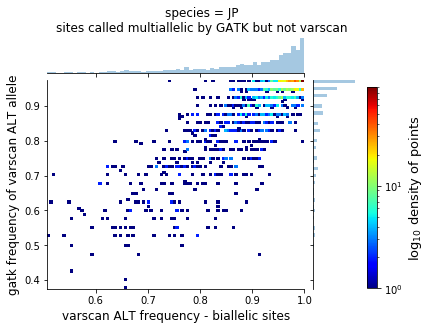

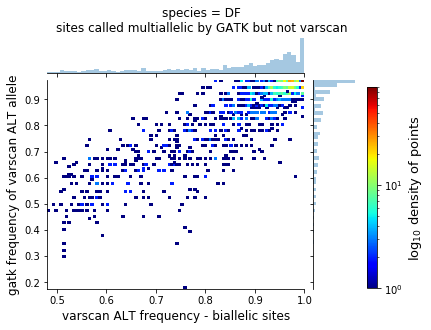

In [128]:
# plot GATK noREF snps vs same sites detected in VarScan - show pretty good agreement
for sp,df in nrsnps['gatk'].items():
    freqcol = [col for col in snps['varscan'][sp] if 'FREQ' in col][0]
    x = nrsnps['varscan'][sp][freqcol].str.replace("%","").astype(float)/100
    y = df['new_AF']
    print(sp, pearsonr(x,y))
    makesweetgraph(x, y,
                   title='species = %s\nsites called multiallelic by GATK but not varscan' % sp,
                   xlab='varscan ALT frequency - biallelic sites',
                   ylab='gatk frequency of varscan ALT allele')

In [153]:
def getafcol(df):
    """Determine which Allele Frequency column to use."""
    return 'new_AF' if 'new_AF' in df.columns else 'AF'

In [145]:
# how many are fixed in either method
for method,spp in snps.items():
    for sp,df in spp.items():
        afcol = getafcol(df)
        print(sp, method, sum(df[afcol]==1), "%s%%" % round(sum((df[afcol]==1)/nrow(df))*100,2))

JP gatk 22244 8.66%
DF gatk 25680 4.03%
JP varscan 21178 8.24%
DF varscan 30832 4.84%


In [146]:
# print numer of snps in each dataset
for method,spp in snps.items():
    for sp,df in spp.items():
        print(method, sp, nrow(snps[method][sp]))

gatk JP 256950
gatk DF 637410
varscan JP 256950
varscan DF 637410


#### remove noREF snps from analyses

In [151]:
# remove noREF snps from analyses
for method,spp in snps.items():
    for sp,df in spp.items():
        locuscol = getlocuscol(df)
        snps[method][sp] = df[~df[locuscol].isin(ploci[sp])].copy()
        print(method, sp, nrow(snps[method][sp]))

gatk JP 255706
gatk DF 636279
varscan JP 255706
varscan DF 636279


In [152]:
# save datasets without noREF SNPs as pkls
norefpkl = op.join(firstdir, 'snps_dict_intersecting_no-noREFloci.pkl')
pkldump(snps, norefpkl)

In [1]:
# make sure they're there
fs(firstdirs)

['/data/home/lindb/methods_paper_analysis/001_testdata_explore/snps_dict_intersecting_loci.pkl',
 '/data/home/lindb/methods_paper_analysis/001_testdata_explore/snps_dict_intersecting_noREFloci.pkl']

In [4]:
# read back in the data
snps = pklload(op.join(firstdir, 'snps_dict_intersecting_no-noREFloci.pkl'))
for method,spp in snps.items():
    for sp,df in spp.items():
        print(method, sp, df.shape)

gatk JP (255706, 117)
gatk DF (636279, 117)
varscan JP (255706, 21)
varscan DF (636279, 21)


#### it looks like adjusting freqs makes things bad, let's see across all bedfiles

In [1]:
from pythonimports import *

In [2]:
# load engines
lview,dview = get_client()

20 20


In [3]:
def unzip(f):
    """gunzip to make reading vcf easier."""
    import os
    import shutil
    import subprocess
    if os.path.exists(f):
        os.chdir(os.path.dirname(f))
        gunzip = shutil.which('gunzip')
        output = subprocess.check_output([gunzip, '--force', f]).decode('utf-8').replace("\n", "").split()
    return f

In [8]:
files = fs('/data/projects/pool_seq/non-pangenome/varscan_pooled/JP_pooled/snpsANDindels/raw_vcfs_and_tables',
           endswith='.gz')
len(files)

29

In [9]:
# unzip files in parallel
jobs = make_jobs(files, unzip, lview)
watch_async(jobs)

29
29


In [4]:
def bgzip(f):
    """bgzip file f."""
    import os
    import shutil
    if os.path.exists(f):
        os.chdir(os.path.dirname(f))
        bgzip = shutil.which('bgzip')
        os.system(f'{bgzip} --force {f}')
    return f
dview['bgzip'] = bgzip

def create_table(f):
    """Create VariantsToTable.txt file from vcf."""
    import os
    import subprocess
    newf = f.replace('raw_vcfs_and_tables', 'test').replace('.vcf','_table.txt')
    gatk = '/data/programs/gatk-4.1.0.0/gatk'
    cmd = f'''{gatk} VariantsToTable \
--variant {f} \
-F CHROM -F POS -F REF -F ALT -F AF -F QUAL -F TYPE -F FILTER -F ADP -F WT -F HET -F HOM -F NC -GF GT -GF GQ \
-GF SDP -GF DP -GF FREQ -GF PVAL -GF AD -GF RD \
-O {newf} \
--split-multi-allelic'''
    print(cmd)
    output = subprocess.check_output(cmd.split()).decode('utf-8').replace("\n", "").split()[-1]
    if os.path.exists(newf):
        f = bgzip(f)
    return newf,output

In [5]:
files = fs('/data/projects/pool_seq/non-pangenome/varscan_pooled/JP_pooled/snpsANDindels/raw_vcfs_and_tables',
          endswith='.vcf')
len(files)

1101

In [10]:
jobs2 = make_jobs(files, create_table, lview)
watch_async(jobs2)

764
1101


KeyboardInterrupt: 

#### not all jobs finished (764/1101), but let's see what we get

In [20]:
# reset engines
lview,dview = get_client()

56 56


In [25]:
def getdf(f):
    """Read in VariantsToTable output, create a 'locus' column."""
    import pandas
    
    dfs = []
    for df in pandas.read_table(f, chunksize=10000):
        df['locus'] = ["%s-%s" % (chrom,pos) for (chrom,pos) in zip(df['CHROM'],df['POS'])]
        df.index = df['locus'].tolist()
        df = df[df.index.isin(varscanloci)].copy()
        dfs.append(df)
        
    return pandas.concat(dfs)
dview['varscanloci'] = snps['varscan']['JP']['locus'].tolist()

In [22]:
# get the VariantsToTable output files that finished
files = fs('/data/projects/pool_seq/non-pangenome/varscan_pooled/JP_pooled/snpsANDindels/test', endswith='.txt')
len(files)

787

In [28]:
# read in VariantsToTable outputs in parallel
jobs = make_jobs(files, getdf, lview)
watch_async(jobs)

787
787


In [42]:
# get the returns, convert column names
varscandata = pd.concat([j.r for j in jobs])
varscandata = get_varscan_names(varscandata,
                                '/data/projects/pool_seq/non-pangenome/varscan_pooled/JP_pooled/poolsamps.pkl',
                                'JP_pooled')
varscandata.shape

renaming varscan columns ...


(228278, 334)

In [43]:
# check to make sure all loci coming out are also in gatk
len(set(varscandata['locus'].tolist()).intersection(snps['gatk']['JP']['locus'].tolist()))

228278

#### what does correlation look with raw intersection? (after adjusting noREF snp freq in gatk)

In [47]:
from scipy.stats import pearsonr

In [52]:
# copy dataframe to easy-named object "gatk"
snps['gatk']['JP'].index = snps['gatk']['JP']['locus'].tolist()
gatk = snps['gatk']['JP'].copy()

In [156]:
# copy dataframe to easy-named object "vdata"
vdata = varscandata[varscandata.index.isin(gatk.index.tolist())].copy()
vdata.shape, gatk.shape

((228278, 334), (228278, 114))

In [60]:
# reduce gatk data to the SNPs in the VarScan data
gatk = gatk[gatk.index.isin(vdata.index)].copy()

In [62]:
# rows, cols
gatk.shape

(228278, 114)

In [157]:
# reorient the VarScan data in the same order as the GATK data
vdata = vdata.loc[gatk.index, :].copy()

In [263]:
# adjust freq in GATK
gatk.loc[gatk['ALT'].str.contains("+",regex=False), 'AF'] = 1 - gatk.loc[gatk['ALT'].str.contains("+",regex=False), 'AF']

In [264]:
# what is the correlation of the data
pearsonr(vdata['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gatk['AF'])

(0.9761389392068591, 0.0)

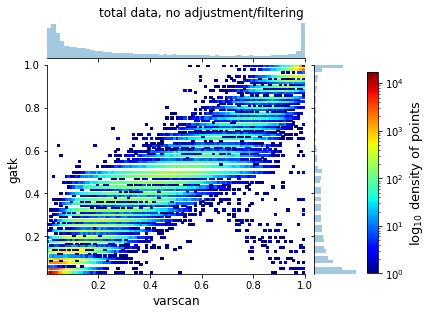

In [265]:
# plot the data - bottom right isn't weird, just needs an adjustment (1-AF)
makesweetgraph(vdata['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gatk['AF'],
              xlab='varscan', ylab='gatk', title="total data, no adjustment/filtering")

#### what if we adjust FREQ so denominator = AD + RD?  
#### A: decreases correlation

In [266]:
# adjust VarScan FREQ by dividing AD / (AD + RD) - instead of AD / DP
vdata['JP_p101_new.FREQ'] = vdata['JP_p101.AD'] / (vdata['JP_p101.AD'] + vdata['JP_p101.RD'])
pearsonr(vdata['JP_p101_new.FREQ'], gatk['AF'])

(0.9754240960429793, 0.0)

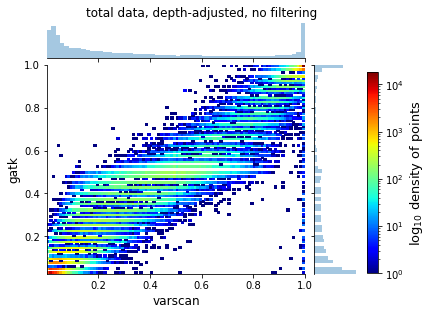

In [267]:
# the bottom right now are closer to 1.0 frequency
makesweetgraph(vdata['JP_p101_new.FREQ'], gatk['AF'],
              xlab='varscan', ylab='gatk', title='total data, depth-adjusted, no filtering')

In [268]:
vdata.shape

(228278, 335)

#### what are the SNPs in the bottom right of unadjusted ("total data, no adjustment/filtering" figure)?

In [269]:
# try and isolate the bottom-right loci by figure coordinates
weird_var = vdata[(vdata['JP_p101.FREQ'].str.replace("%","").astype(float) / 100) >0.7].copy()  # x-axis
# weird_var = vdata.copy()
weird_gatk = gatk[gatk['AF']<0.4].copy()  # y-axis
interloci = set(weird_var.index).intersection(weird_gatk.index)
len(interloci)

121

In [270]:
# get small dataframes with the weird loci
weird_var = weird_var[weird_var.index.isin(interloci)].copy()
weird_gatk = weird_gatk[weird_gatk.index.isin(interloci)].copy()
weird_var.shape, weird_gatk.shape

((121, 335), (121, 114))

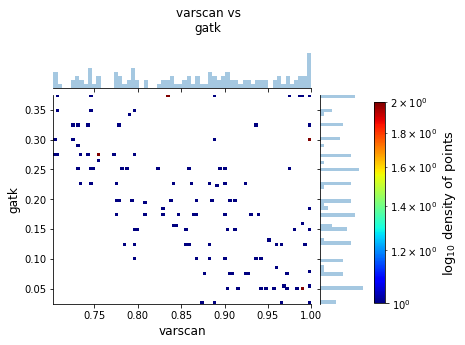

In [271]:
makesweetgraph(weird_var['JP_p101.FREQ'].str.replace("%","").astype(float)/100, weird_gatk['AF'],
              xlab='varscan', ylab='gatk')

In [274]:
pearsonr(1-weird_var['JP_p101.FREQ'].str.replace("%","").astype(float)/100, weird_gatk['AF'])

(0.45617819641637225, 1.4531689901704265e-07)

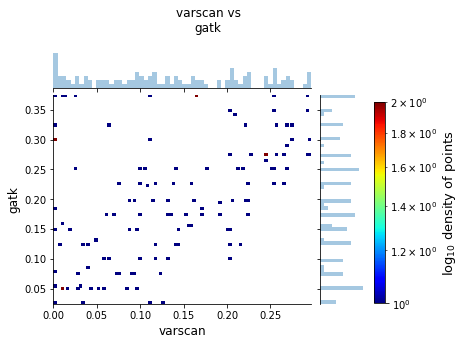

In [275]:
makesweetgraph(1-weird_var['JP_p101.FREQ'].str.replace("%","").astype(float)/100, weird_gatk['AF'],
              xlab='varscan', ylab='gatk')

In [277]:
goodcols = [col for col in vdata if '.' not in col]
goodcols.extend([col for col in vdata if 'JP_p101' in col])
weird_var[goodcols]

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,locus,JP_p101.GT,JP_p101.GQ,JP_p101.SDP,JP_p101.DP,JP_p101.FREQ,JP_p101.PVAL,JP_p101.AD,JP_p101.RD,JP_p101_new.FREQ
Scaffold_35-476207,Scaffold_35,476207,T,G,NaN,-10.0,SNP,PASS,93,0,21,19,0,Scaffold_35-476207,T/G,254.0,59,59.0,74.58%,3.809700e-26,44.0,0.0,1.000000
Scaffold_151-668199,Scaffold_151,668199,T,A,NaN,-10.0,SNP,PASS,121,0,0,40,0,Scaffold_151-668199,A/A,255.0,73,73.0,97.26%,2.683500e-42,71.0,0.0,1.000000
Scaffold_154-4551691,Scaffold_154,4551691,C,T,NaN,-10.0,SNP,PASS,86,0,4,36,0,Scaffold_154-4551691,T/T,255.0,63,63.0,96.83%,2.609000e-36,61.0,0.0,1.000000
Scaffold_155-126984,Scaffold_155,126984,C,T,NaN,-10.0,SNP,PASS,127,0,34,6,0,Scaffold_155-126984,C/T,255.0,80,80.0,78.75%,1.657000e-37,63.0,0.0,1.000000
Scaffold_167-1649702,Scaffold_167,1649702,A,G,NaN,-10.0,SNP,PASS,100,0,3,37,0,Scaffold_167-1649702,G/G,255.0,69,69.0,88.41%,2.000100e-33,61.0,3.0,0.953125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scaffold_4937-1236986,Scaffold_4937,1236986,A,G,NaN,-10.0,SNP,PASS,107,0,4,36,0,Scaffold_4937-1236986,G/G,255.0,94,94.0,90.36%,1.469400e-38,75.0,8.0,0.903614
Scaffold_4937-1236999,Scaffold_4937,1236999,C,T,NaN,-10.0,SNP,PASS,126,0,0,40,0,Scaffold_4937-1236999,T/T,255.0,117,117.0,100%,6.952000e-70,117.0,0.0,1.000000
Scaffold_5839-74825,Scaffold_5839,74825,G,A,NaN,-10.0,SNP,PASS,176,0,13,27,0,Scaffold_5839-74825,A/A,255.0,85,85.0,83.53%,4.155400e-34,71.0,14.0,0.835294
Scaffold_6215-664813,Scaffold_6215,664813,C,T,NaN,-10.0,SNP,PASS,230,0,17,23,0,Scaffold_6215-664813,C/T,255.0,171,171.0,79.53%,1.130600e-62,136.0,35.0,0.795322


In [278]:
# compare the freqs. Looks like the weird loci just need adjustment (1-AF)
pd.concat([pd.DataFrame(weird_var['JP_p101.FREQ'].str.replace("%","").astype(float)/100).T, 
          pd.DataFrame(weird_gatk['AF']).T]).T

,JP_p101.FREQ,AF
Scaffold_35-476207,0.7458,0.375
Scaffold_151-668199,0.9726,0.075
Scaffold_154-4551691,0.9683,0.053
Scaffold_155-126984,0.7875,0.250
Scaffold_167-1649702,0.8841,0.200
...,...,...
Scaffold_4937-1236986,0.9036,0.150
Scaffold_4937-1236999,1.0000,0.150
Scaffold_5839-74825,0.8353,0.375
Scaffold_6215-664813,0.7953,0.350


In [289]:
# count stuff
lst = [1 if '+' in alt else 0 for alt in weird_gatk['ALT']]
lst.count(1), lst.count(0)  # noREF, non noREF in wierd data

(98, 23)

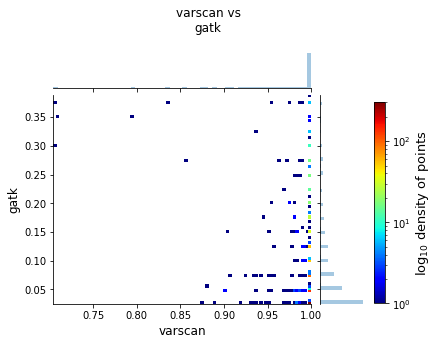

In [101]:
makesweetgraph(weird_var['JP_p101_new.FREQ'], weird_gatk['AF'],
              xlab='varscan', ylab='gatk')

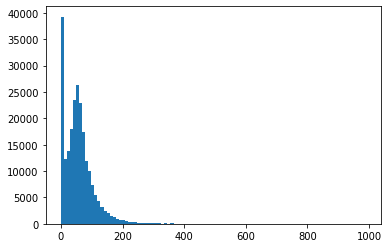

In [294]:
# are the weird loci due to weird RD vals? A: No, look pretty normal.
plt.hist(vdata['JP_p101.RD'][vdata['JP_p101.RD']<1000], bins=100)
plt.show()

#### what does it look like if I remove SNPs with depth probs ONLY when RD=0?   #  A: doesn't change much

In [299]:
# remove SNPs that have FREQ != AD/DP !AND! have RD=0
test = vdata[(vdata['JP_p101.RD']==0) & ((vdata['JP_p101.AD']+vdata['JP_p101.RD']) != vdata['JP_p101.DP'])].copy()
nrow(test)

2324

In [300]:
# how many intersect with the weird loci?
len(set(test.index).intersection(weird_var.index))

92

(0.9763035347076849, 0.0)


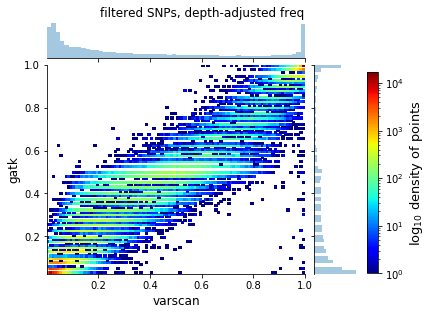

In [301]:
# see if adjusting works A: kinda meh
vadjusted = vdata[~vdata.index.isin(test.index)].copy()
gadjusted = gatk[~gatk.index.isin(test.index)].copy()
print(pearsonr(vadjusted['JP_p101_new.FREQ'], gadjusted['AF']))
makesweetgraph(vadjusted['JP_p101_new.FREQ'], gadjusted['AF'],
              xlab='varscan', ylab='gatk', title="filtered SNPs, depth-adjusted freq")

(0.9763500243425801, 0.0)


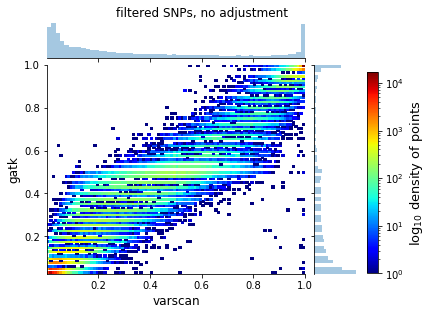

In [302]:
# compare to correlation of unadjusted FREQ - A: unadjusted is slightly worse, but prob not significantly
print(pearsonr(vadjusted['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gadjusted['AF']))
makesweetgraph(vadjusted['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gadjusted['AF'],
              xlab='varscan', ylab='gatk', title='filtered SNPs, no adjustment')

#### what happens when I adjust freq to 100% for all the varscan SNPs with RD=0 AND DP!=AD+RD?
A: r goes down a little bit

In [304]:
# using data: RD==0 && DP!=AD+RD, change freq to 100%
v100 = vdata.copy()
v100.loc[v100.index.isin(test.index), 'JP_p101.FREQ'] = '100%'
pearsonr(v100['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gatk['AF'])

(0.9754656288531, 0.0)

#### look at noREF snps

In [193]:
# get the noREF SNPs (these have 'alt1+alt2' ALT alleles (from our pipelines), note the '+')
multigatk = gatk[gatk['ALT'].str.contains('+',regex=False)].copy()
multivarscan = vdata[vdata.index.isin(multigatk.index)].copy()  # get intersection
nrow(multigatk)

1106

#### how many varscan SNPs have depth descrepancies (DP != AD + RD)?

In [210]:
sum(vdata['JP_p101.DP'] != (vdata['JP_p101.AD']+vdata['JP_p101.RD']))

16339

#### explore data when DP != AD + RD - A: nothing super weird going on, correlation decreases to about 0.955 (still high)

In [328]:
# isolate data
dpvar = vdata[vdata['JP_p101.DP'] != (vdata['JP_p101.AD']+vdata['JP_p101.RD'])].copy()
dpgatk = gatk[gatk.index.isin(dpvar.index)].copy()
dpvar.shape, dpgatk.shape

((16339, 335), (16339, 114))

In [322]:
sum(dpvar['JP_p101.RD']<200), max(dpvar['JP_p101.RD'])

(15349, 5859.0)

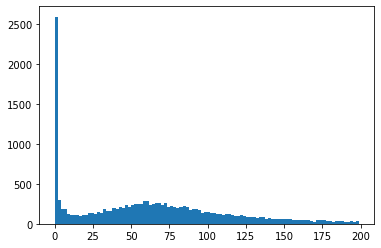

In [323]:
# look at RD histogram
plt.hist(dpvar['JP_p101.RD'][dpvar['JP_p101.RD']<200],bins=100)
plt.show()

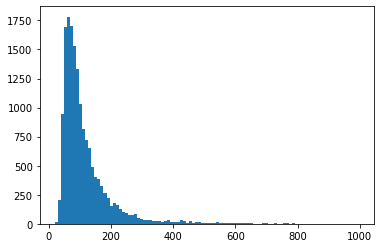

In [324]:
# look at DP histogram
plt.hist(dpvar['JP_p101.DP'][dpvar['JP_p101.DP']<1000],bins=100)
plt.show()

In [325]:
pearsonr(dpvar['JP_p101.FREQ'].str.replace("%","").astype(float)/100, dpgatk['AF'])

(0.9556260043913264, 0.0)

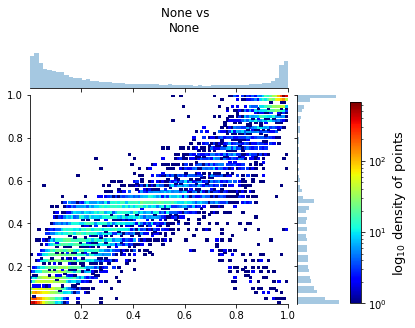

In [356]:
makesweetgraph(dpvar['JP_p101.FREQ'].str.replace("%","").astype(float)/100, dpgatk['AF'])

(0.9778114258206512, 0.0)


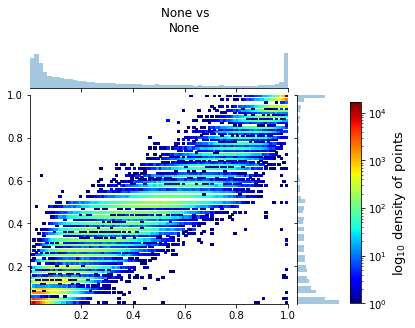

In [327]:
# fix the bottom right stuff
goodvar = vdata[~vdata.index.isin(dpvar.index)].copy()
goodgatk = gatk[~gatk.index.isin(dpvar.index)].copy()
print(pearsonr(goodvar['JP_p101.FREQ'].str.replace("%","").astype(float)/100, goodgatk['AF']))
makesweetgraph(goodvar['JP_p101.FREQ'].str.replace("%","").astype(float)/100, goodgatk['AF'])

In [331]:
print(pearsonr(vdata['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gatk['AF']))

(0.9761389392068591, 0.0)


In [337]:
float(weird_var.loc['Scaffold_35-476207', 'JP_p101.FREQ'].replace("%","")) / 100

0.7458

In [338]:
gatk2 = gatk.copy()
for locus in weird_var.index:
    varfreq = float(weird_var.loc[locus, 'JP_p101.FREQ'].replace("%","")) / 100
    gatkfreq = float(weird_gatk.loc[locus, 'AF'])
    if (varfreq > 0.5 and gatkfreq < 0.5) or (varfreq < 0.5 and gatkfreq > 0.5):
        gatk2.loc[locus, 'AF'] = 1 - gatk2.loc[locus, 'AF']

pearsonr(vdata['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gatk2['AF'])

(0.977248272136013, 0.0)

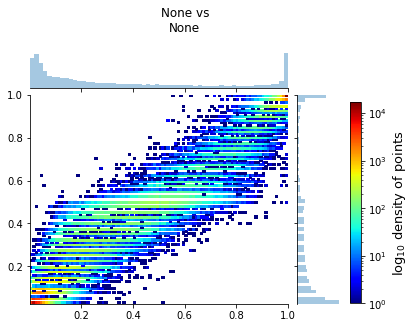

In [344]:
makesweetgraph(vdata['JP_p101.FREQ'].str.replace("%","").astype(float)/100, gatk2['AF'],bins=100)

(0.9768311147493849, 0.0)


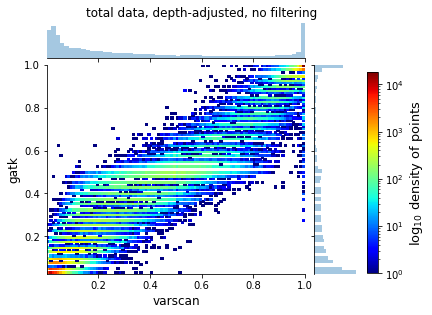

In [345]:
print(pearsonr(vdata['JP_p101_new.FREQ'], gatk2['AF']))
makesweetgraph(vdata['JP_p101_new.FREQ'], gatk2['AF'],
              xlab='varscan', ylab='gatk', title='total data, depth-adjusted, no filtering')